# Тестирование атаки патчами из библиотеки ART на YOLOv8

## Импорты и вспомогательные функции

In [43]:
import numpy as np
import os
import torch
from torchvision import transforms
from PIL import Image
from types import SimpleNamespace
from matplotlib import pyplot as plt
import cv2

from ultralytics import YOLO
from ultralytics.utils.loss import v8DetectionLoss

from art.estimators.object_detection import PyTorchYolo
from art.attacks.evasion import AdversarialPatchPyTorch
from art.attacks.evasion import RobustDPatch

## Свернуть


In [41]:
COCO_INSTANCE_CATEGORY_NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
        'teddy bear', 'hair drier', 'toothbrush']

def get_image_with_boxes(img, labels, confidence=0.15):
    text_size = 1
    text_th = 3
    rect_th = 2

    boxes = labels.get('boxes')
    pred_cls = labels.get('labels')
    scores = labels.get('scores')

    for i in range(len(boxes)):
        if scores[i] >= confidence:
            cv2.rectangle(img, (int(boxes[i][0]), int(boxes[i][1])), (int(boxes[i][2]), int(boxes[i][3])),
                          color=(0, 255, 0), thickness=rect_th)
            cv2.putText(img, f"{COCO_INSTANCE_CATEGORY_NAMES[pred_cls[i]]} {round(float(scores[i]), 2)}",
                        (int(boxes[i][0]), int(boxes[i][1]) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)

    return img

def show_predictions(patched_images, clean_images, patch_title, model):
    clean_preds = model.predict(clean_images)
    patched_preds = model.predict(patched_images)

    for i in range(len(patched_preds)):
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))

        im_adv = (patched_images[i]).transpose(1, 2, 0) * 255
        im_adv_boxed = get_image_with_boxes(im_adv.copy(), patched_preds[i])
        axs[0].imshow(im_adv_boxed.astype("uint8"))
        axs[0].set_title(patch_title)
        axs[0].axis("off")

        im_orig = (coco_images[i]).transpose(1, 2, 0) * 255
        im_orig_boxed = get_image_with_boxes(im_orig.copy(), clean_preds[i])
        axs[1].imshow(im_orig_boxed.astype("uint8"))
        axs[1].set_title("Original")
        axs[1].axis("off")

def save_patch(patch, filename):
    # 1. Транспонируем в формат (H, W, C)
    patch_hwc = np.transpose(patch, (1, 2, 0))

    # 2. Нормализуем значения (если патч в [-1, 1] или [0, 1])
    if patch_hwc.min() < 0:  # Предполагаем, что патч в [-1, 1]
        patch_hwc = (patch_hwc + 1) * 127.5  # Масштабируем в [0, 255]
    elif patch_hwc.max() <= 1:  # Если патч в [0, 1]
        patch_hwc = patch_hwc * 255

    # 3. Конвертируем в uint8 и сохраняем
    patch_uint8 = patch_hwc.astype(np.uint8)
    Image.fromarray(patch_uint8).save(filename)

In [2]:
NUM_SAMPLES = 10
IMAGE_DIR = "coco_data/val2017"
IMG_SIZE = 640
NUMBER_CHANNELS = 3
INPUT_SHAPE = (NUMBER_CHANNELS, IMG_SIZE, IMG_SIZE)

# Преобразования
transform = transforms.Compose([
    transforms.Resize(int(INPUT_SHAPE[1]), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(int(INPUT_SHAPE[1])),
    transforms.ToTensor()
])

def get_images(num):
    # Получаем список файлов
    image_files = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)
                   if f.endswith(('.jpg', '.jpeg', '.png'))][:num]
    image_files.sort()

    # Загрузка и преобразование изображений
    coco_images = []
    for img_path in image_files:
        try:
            img = Image.open(img_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_tensor = transform(img)
            coco_images.append(img_tensor.numpy())
        except Exception as e:
            print(f"Ошибка обработки {img_path}: {str(e)}")

    # Преобразование в numpy array
    return np.array(coco_images)  # (N, 3, 640, 640)

coco_images = get_images(NUM_SAMPLES)

In [4]:
# https://docs.ultralytics.com/models/
MODEL = 'yolov8s.pt'
DEVICE = 'cpu'


class YoloWrapper(torch.nn.Module):
    def __init__(self, model, device, **kwargs):
        super().__init__(**kwargs)
        self.orig_model = YOLO(model)
        if device == 'cuda' or device == 'gpu':
            self.orig_model.cuda()
        self.model = self.orig_model.model
        self.predict_count = 0
        self.conf = 0.5
        self.device = device

        for param in self.model.parameters():
            param.requires_grad = False

        self.loss_fn = v8DetectionLoss(self.model, tal_topk=10)
        self.loss_fn.hyp = SimpleNamespace(box=7.5, cls=0.5, dfl=1.5)

    def forward(self, x, targets=None):
        if isinstance(x, torch.Tensor):
            x = x.to(self.device)
        elif isinstance(x, np.ndarray):
            x = torch.from_numpy(x).to(self.device)

        if self.training:

            batch = {
                "batch_idx": targets[:, 0].long(),
                "cls": targets[:, 1].long(),
                "bboxes": targets[:, 2:6].float(),
            }
            loss_total, loss_tensor = self.loss_fn(self.model(x), batch)

            loss_dict = {
                'loss_box': loss_total[0],
                'loss_cls': loss_total[1],
                'loss_dfl': loss_total[2]
            }

            return loss_dict

        else:
            pred = self.model(x)[0]  # (n, 84, 8400)

            boxes = pred[:, 0:4, :]  # (n, 4, 8400)
            class_scores = pred[:, 4:, :]  # (n, 80, 8400)

            # ART requires objectness score for each bbox, so here's a trick:
            objectness, _ = class_scores.max(dim=1)  # (n, 8400)
            objectness = objectness.unsqueeze(1)  # (n, 1, 8400)

            pred = torch.cat([
                boxes,  # (n, 4, 8400)
                objectness,  # (n, 1, 8400)
                class_scores  # (n, 80, 8400)
            ], dim=1)  # -> (n, 85, 8400)

            pred = pred.permute(0, 2, 1)  # (n, 8400, 85)

            return pred

    def predict(self, x, postprocess=False):
        self.orig_model.model.eval()
        results = self.orig_model(torch.tensor(x, device=self.device), verbose=False)
        outputs = []
        for result in results:
            if postprocess:
                boxes = result.boxes.xyxy.cpu().numpy()
                scores = result.boxes.conf.cpu().numpy()
                labels = [result.names.get(int(l), "unk") for l in result.boxes.cls]
            else:
                boxes = result.boxes.xyxy
                scores = result.boxes.conf
                labels = result.boxes.cls.int()

            outputs.append({
                'boxes': boxes,
                'labels': labels,
                'scores': scores
            })
        return outputs

    def train(self, state=True):
        self.model.train() if state else self.model.eval()
        self.training = state


model = YoloWrapper(MODEL, DEVICE)

detector = PyTorchYolo(model=model,
                    device_type=DEVICE,
                    input_shape=(3, 640, 640),
                    clip_values=(0, 1),
                    attack_losses=("loss_cls",
                                    "loss_box",
                                    "loss_dfl"),)

## Adversarial Patch

https://arxiv.org/abs/1712.09665

Нацелен на модели-классификаторы, а не детекторы, так что будет неудивительно, если он окажется неэффективен

In [7]:
atk = AdversarialPatchPyTorch(estimator=detector,
                              targeted=False,
                              verbose=True,
                              max_iter=100)

patch = atk.generate(x=coco_images)
save_patch(patch, 'adversarial_patch100.png')

Adversarial Patch PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

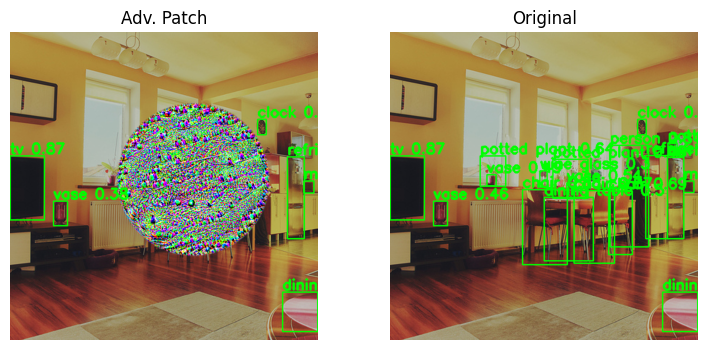

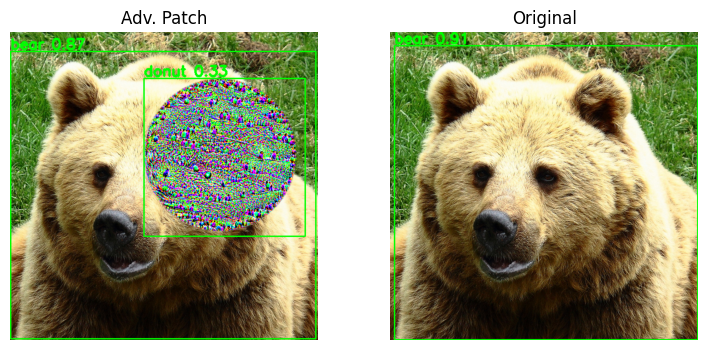

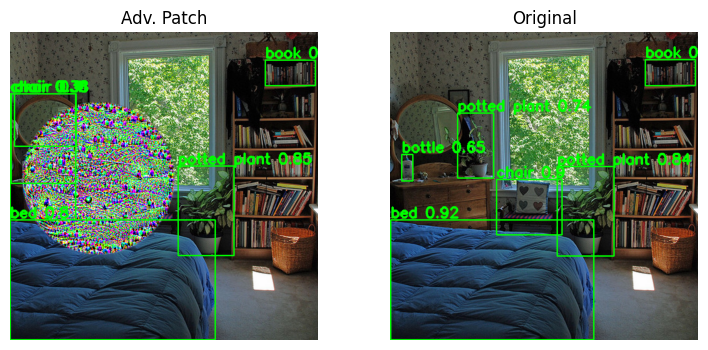

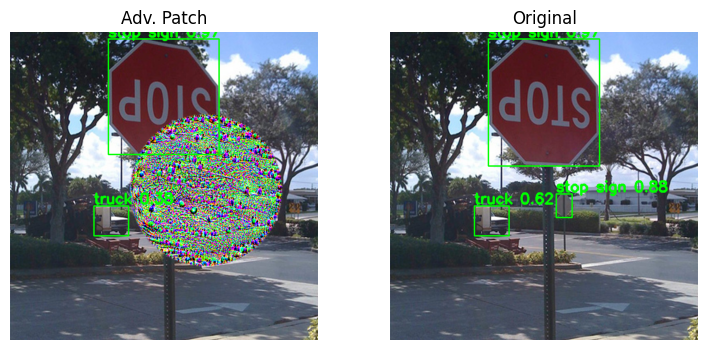

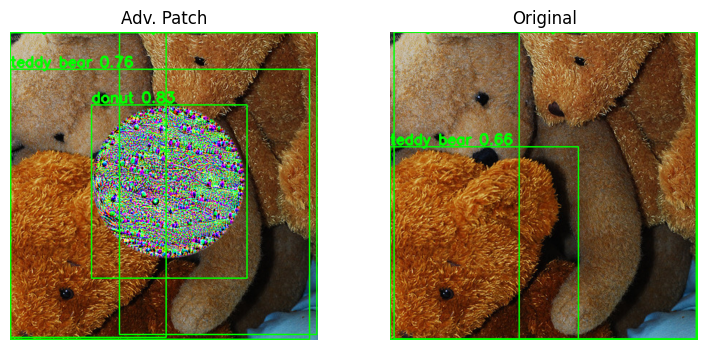

In [42]:
atk = AdversarialPatchPyTorch(estimator=detector,
                              targeted=False,
                              verbose=True)
transform = transforms.ToTensor()
atk._patch = transform(Image.open('adversarial_patch100.png'))
patched_images = atk.apply_patch(coco_images[:5], 0.5)
show_predictions(patched_images, coco_images, patch_title="Adv. Patch", model=detector.model)

### Вывод по Adv. Patch

Даже при большой величине патча, он почти не влияет на предсказания. Изменения обусловлены тем, что он физически закрывает часть изображения, а вот сам эффект от патча не заметен.

## DPatch

https://arxiv.org/abs/1806.02299

Данный вид атаки специально сделан для детекторов. Согласно статье, он должен стирать предсказания модели независимо от положения патча на изображении

Robust DPatch является модификацией обычного DPatch, которая должна быть более стойка к изменениям в изображении

### 100 итераций, размер 80х80

В статье показана эффективность и патча 40х40, а также сказано, что больший размер патча повышает эффективность

In [44]:
atk = RobustDPatch(
    detector,
    patch_shape=(3, 80, 80),
    max_iter=100,
    batch_size=16
)
patch = atk.generate(x=coco_images)
save_patch(patch, 'dpatch100.png')

RobustDPatch iteration:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

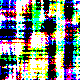

In [52]:
Image.open('dpatch100.png')

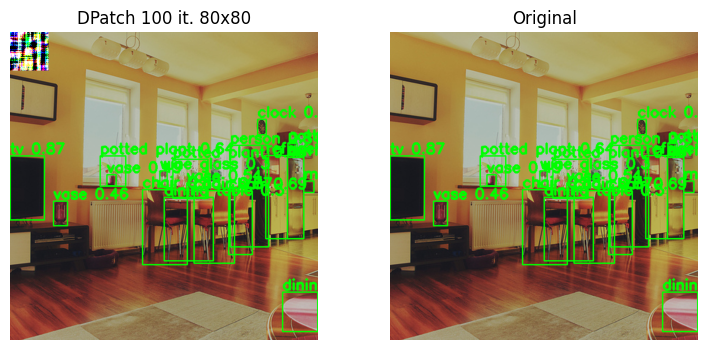

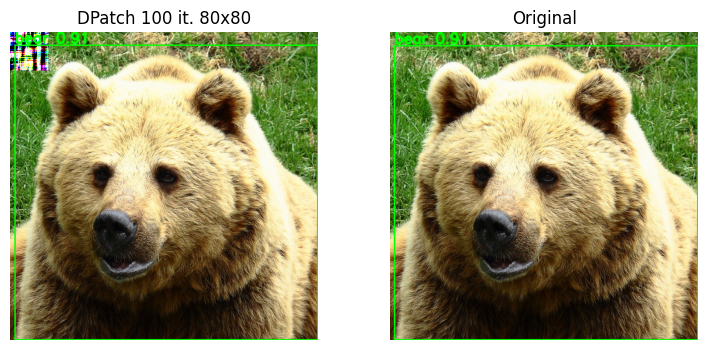

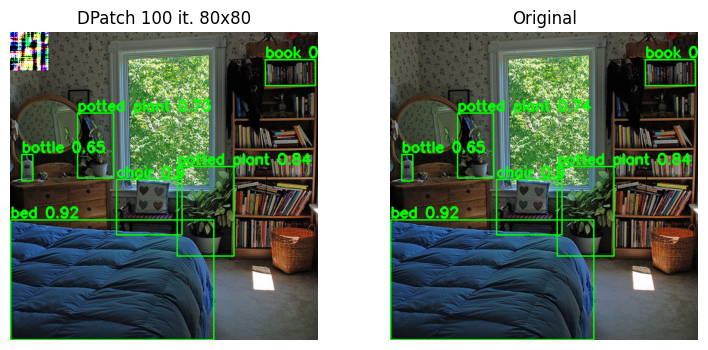

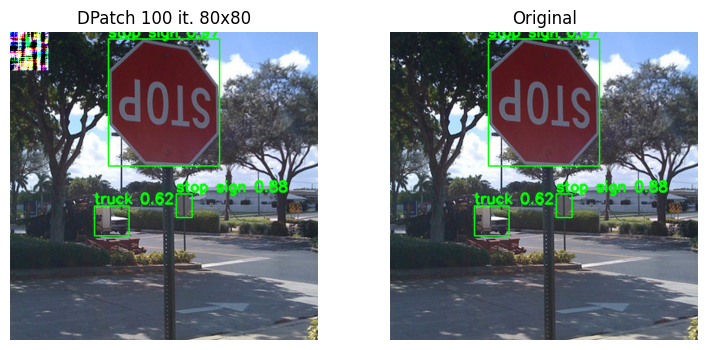

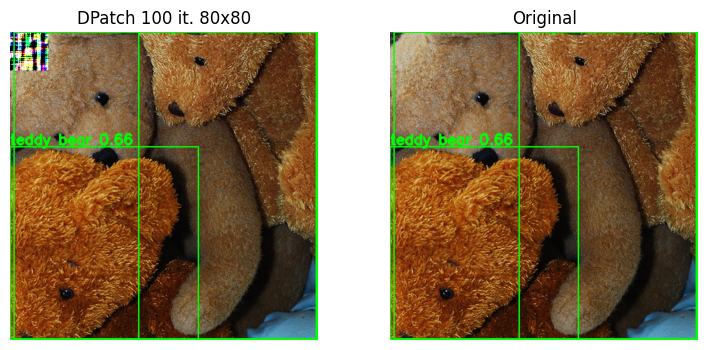

In [56]:
atk = RobustDPatch(
    detector,
    patch_shape=(3, 80, 80),
    max_iter=100,
    batch_size=16
)
atk._patch = transform(Image.open('dpatch100.png')).numpy()
patched_images = atk.apply_patch(coco_images[:5])
show_predictions(patched_images, coco_images, patch_title="DPatch 100 it. 80x80", model=detector.model)

### 500 итераций, размер 160х160

In [58]:
atk = RobustDPatch(
    detector,
    patch_shape=(3, 160, 160),
    max_iter=500,
    batch_size=16
)
patch = atk.generate(x=coco_images)
save_patch(patch, 'dpatch500.png')

RobustDPatch iteration:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

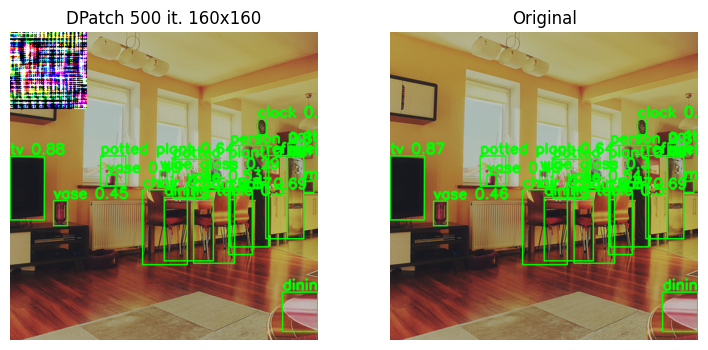

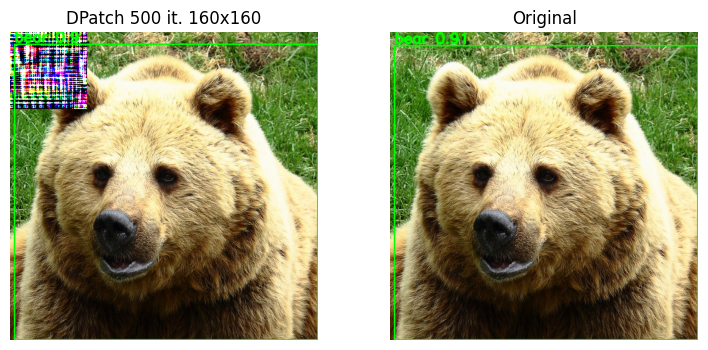

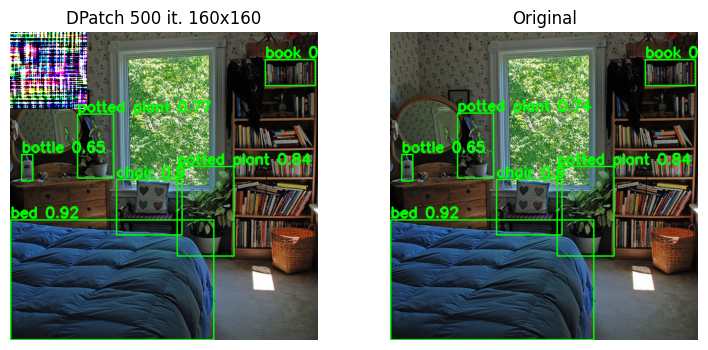

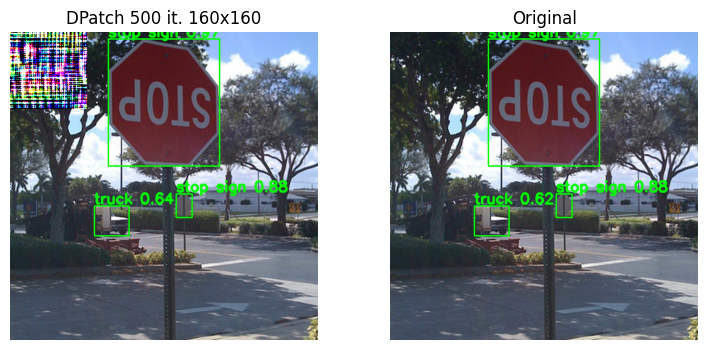

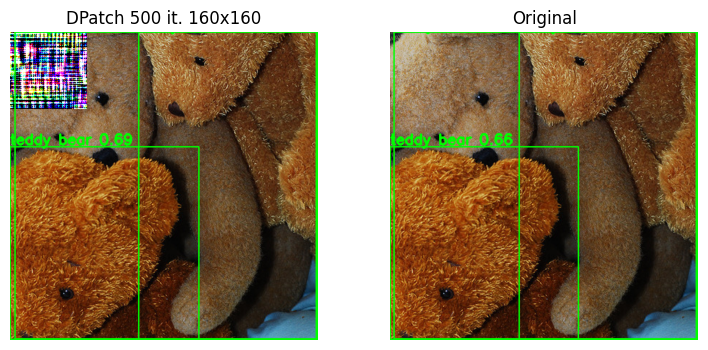

In [59]:
atk = RobustDPatch(
    detector,
    patch_shape=(3, 160, 160),
    max_iter=500,
    batch_size=16
)
atk._patch = transform(Image.open('dpatch500.png')).numpy()
patched_images = atk.apply_patch(coco_images[:5])
show_predictions(patched_images, coco_images, patch_title="DPatch 500 it. 160x160", model=detector.model)

0 влияния патча на предсказания модели

# Вывод

Представленные в ART методы генерации патчей являются неэффективными для YOLOv8. Скорее всего это связано с тем, что представленные здесь Adversarial Patch и DPatch создавались для намного более ранних моделей YOLO, и изменения в структуре более новых моделей делает их устойчивее к таким видам атак